# GNN with Positional Encoding
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import torch

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

In [19]:
from collections import OrderedDict
from simgnn.datasets import clear_processed, VertexDynamics, HaraMovies, HaraAblation
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, RecoilAsTension
from simgnn.transforms import AppendReversedEdges, AppendDiff_x, Reshape_x , AppendEdgeLen

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Data, Stat-s, Transforms

Notes for normalisation param-s:

- Use `simgnn.transforms` to normalise real--Hara movies and ablation,  and simulated movies.
- For ablation movies, convert to  HaraMovies length scale (pixels) and use same `l_av` as for HaraMovies dataset.

---
|Dataset| Avg. edge len.|Tension/Recoil| Transforms (Normalisation)|Notes|
|:---:|:---:|---:|:---|:---:|
|`single_distr_sims` | 1.08 a.u. | range = [0.00131, 4.26]; sd=0.637; median=0.305; mean=0.578; | `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/o base tension |
|`unimodal_wbasetens_sims` | 0.906 a.u. | range=[0.407, 5.47]; sd=0.729; median=1.48; mean=1.6| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/ non-zero base tension |
|`HaraMovies`  | 26.32 pixels||`[Pos2Vec(scale=10*26.32)`, `ScaleVelocity(0.5*26.32)]`| tissue movies w/o force data|
|`HaraAblation`|$26.32\cdot\frac{0.4}{0.21}$ pixels| range=[0.0239, 2.61]; sd=0.651; median=0.673; mean=0.826 | `[Pos2Vec(scale=10*50.13), ScaleVelocity(0.5*50.13)]`| short movies w/ recoil data; frame rate:dataset contains vertex positions only from every 10th frame |


### Datasets

---
- **Input features for transforms**

In [21]:
# Data normalisation param-s : sim="default" for simulation data
# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

# Input features
window_size = 5
print(f'> Set features window size to --> {window_size}')
sma_lag_time = 4 # SMA_n : n=sma_lag_time+1
print(f'> Set n for SMA_n --> {sma_lag_time+1}')

pos_noise = None
# pos_noise = torch.normal
# noise_args= [0, 0.01] #[0,1]
print(f'> Input noise --> {pos_noise}')

> Set features window size to --> 5
> Set n for SMA_n --> 5
> Input noise --> None


- **Normalisation param-s (transforms)**

In [22]:
# Simulation datasets
# 'sim' : defaults for all sim-s; l_0 (same for all sim-s)
# '***_sims' : dataset specific param-s; tension
# Normalisation (**no input noise**)
Tnrm = {k: [Pos2Vec(scale=l_0['sim']),
            ScaleVelocity(l_0['sim']), # normalises x and y
            ScaleTension(t_sd[k], shift=t_av[k])] # normalise tensions
        for k in ['sim', 'single_distr_sims', 'unimodal_wbasetens_sims']}


# Node and Edge Feature Transforms
# Convert to undirected graph and append "edge features"
for k in Tnrm:
    # Prepare inputs
    
    # to undirected graph: add e_ji for all e_ij
    Tnrm[k].append(AppendReversedEdges())
    
    # Add edge features
    Tnrm[k].append(AppendDiff_x()) # DiffX feature
    
    # # miscellaneous variables
    Tnrm[k].append(AppendEdgeLen(norm=True, scale=l_0[k])) # for edge masks (not an edge feature)
    
    # flatten  node features
    Tnrm[k].append(Reshape_x((-1,window_size*2)))
    
    Tnrm[k] = T.Compose(Tnrm[k])

In [23]:
Tnrm['unimodal_wbasetens_sims']

Compose([
    Pos2Vec(norm=True, scale=1.0, cat=False, pos_noise=None, noise_args=[], noise_kwargs={}),
    ScaleVelocity(scale=1.0),
    ScaleTension(scale=0.73, shift=1.6),
    AppendReversedEdges(reverse_attr=True, reverse_tension=False, edge_id=True),
    AppendDiff_x(norm=True),
    AppendEdgeLen(keep_dir=False, aggr_edge_id=True, use_edge_attr=False, norm=True, scale=0.91),
    Reshape_x((-1, 10)),
])

- **Load datasets**

In [24]:
data_root = Path('simgnn_data')

# dataset locations
datasets = ['single_distr_sims/train', 
            'single_distr_sims/val',
            'unimodal_wbasetens_sims/train', 
            'unimodal_wbasetens_sims/val' ]

# paths to processed datasets
dataset_paths = [data_root / dset / 'processed' for dset in datasets]

if one of these is changed: `w`, SMA `lag` time, delete the old *processed* dataset files with old `w` or `lag`

In [25]:
# clear processed data (required for clearing older transformations)
clear_processed(dataset_paths)

# Simulation datasets
# rand base contractility
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size,
                      transform=Tnrm['unimodal_wbasetens_sims']
                     )
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size,
                          transform=Tnrm['unimodal_wbasetens_sims']
                         )

# w/o base contractility
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size,
                          transform=Tnrm['single_distr_sims']
                         )


datasets_dict = {'train': sim1,
                 'val': sim1_val[:len(sim1_val)//2]+sim1_val[len(sim1_val)//2:-1],
                 'val2': sim2_val[:len(sim2_val)//2]+sim1_val[len(sim2_val)//2:-1],
                }
dataset_legend={'train': 'Train(sim1)',
                'val': r'Supervised ($\mathcal{D}_{sim1}$)',
                'val2': r'Sim2sim ($\mathcal{D}_{sim2})$',
               }

Skipping:  simgnn_data/single_distr_sims/train/processed (does not exist)
Clearing:  simgnn_data/single_distr_sims/val/processed
Clearing:  simgnn_data/unimodal_wbasetens_sims/train/processed
Clearing:  simgnn_data/unimodal_wbasetens_sims/val/processed
Processing...
Done!
Processing...
Done!
Processing...
Done!


# Positional Encoding

Reading
1. [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://bmild.github.io/fourfeat/index.html)
    - colab nb https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Demo.ipynb
1. [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
1. Related:
    - [NeRF](https://www.matthewtancik.com/nerf)
    - [Multi-scale NeRF](https://jonbarron.info/mipnerf/)
    - [Learned initialisation](https://www.matthewtancik.com/learnit)

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use(['seaborn-paper', 'seaborn-ticks']) # use seaborn-talk for presentations
%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
# matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [27]:
# from torch_geometric.utils import to_networkx, from_networkx
# import networkx as nx
# from simgnn.datautils import load_array, load_graph

In [28]:
# k = 'val2'
# t = 15
# print('{}\n{} : {}\nsize:{}\n\nFrame {}:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),t,datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][t]),pos=dict(enumerate(datasets_dict[k][t].pos.numpy())), node_size=10)

In [29]:
d = datasets_dict['train'][0]

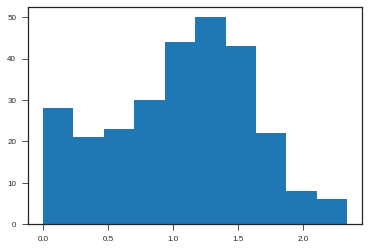

In [33]:
plt.hist(d.edge_length.cpu().numpy());

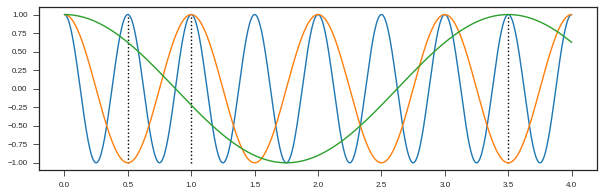

In [108]:
plt.figure(figsize=[10,3])
t = np.linspace(0,4,1024)
for wavelength in [0.5,1,3.5]:
    plt.plot(t,np.cos(np.pi*2*t/wavelength))
    plt.vlines(wavelength,-1,1,'k',linestyles='dotted')

In [116]:
t = np.exp(-np.arange(0, 10, 2) *(np.log(10000.0) / 10))
t

array([1.00000000e+00, 1.58489319e-01, 2.51188643e-02, 3.98107171e-03,
       6.30957344e-04])

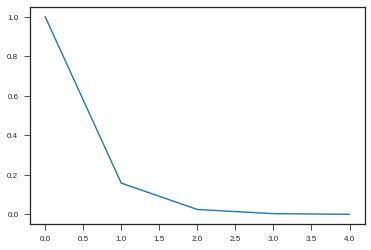

In [117]:
plt.plot(t)